In [20]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import time,datetime
import nltk
from string import punctuation
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer 
import time
import re
import torch
from nltk import word_tokenize
from google.colab import drive
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
import logging
from tqdm import tqdm
from sklearn import model_selection,metrics
import gdown
import seaborn as sns
import string 
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from keras.preprocessing import sequence

In [21]:
!pip freeze --local > /content/installed.txt

In [22]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
df= pd.read_csv('/content/drive/MyDrive/flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.csv')

In [24]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


##Some basic analysis before cleaning and preprocessing

Here we look at the distribution of data and pointing out 
which columns, before cleaning , will play an insignificant role 

We will also get clarity on the product specification column after unwrapping the jformat to create a workable format for our future models.

Lastly, we will have a general statistical outlook on the data distribution!



From the outset, we can observe a few redundencies in the dataset:


*   URL's do not provide any outright benefit to the problem statement. They only provide a link to the webpage which is irrelevant to customer interaction with the product
*   Unique ID's and PID's are not a relevant aspect to the dataset as they have no correlation with other rows and are random strings of numbers assigned to the products. The PID's could allow us to know how many unique products are present, but that can be done directly using the product names, as i've shown below
*   The crawl timestamp is simply the time at which the web crawl for the data extraction had taken place.
*   The image link itself has no contribution to the task in hand. Will try to explore this later if it can be used as a multimodal problem.








Let's now get the data distribution data from each column. Notice that description and product category are essential to the task. We will analyse the other columns first.

In [25]:
df.info() #general data non-null count.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

In [26]:
len(pd.unique(df['product_name'])) #Number of unique products, which means there are duplicates.

12676

In [27]:
df['product_rating'].value_counts()#Analysing the distribution of values in specific columns
#The lack of numerical ratings as a ratio to the length of the entire dataset means this will not have any affect to the task.

No rating available    18151
5                        620
4                        246
1                        171
3                        168
2                         80
4.5                       67
3.7                       51
4.2                       47
3.5                       45
4.3                       45
3.6                       25
4.1                       24
4.7                       24
3.8                       23
2.5                       23
4.8                       21
3.2                       20
3.3                       17
4.4                       16
3.9                       15
3.4                       13
2.3                       12
2.8                       11
2.7                       10
4.6                        9
2.2                        8
3.1                        7
2.9                        5
2.4                        5
1.7                        4
1.5                        4
4.9                        4
1.3                        4
2.6           

In [28]:
df['overall_rating'].value_counts() #Same applies to overall rating, making it irrelevant as well.

No rating available    18151
5                        620
4                        246
1                        171
3                        168
2                         80
4.5                       67
3.7                       51
4.2                       47
3.5                       45
4.3                       45
3.6                       25
4.1                       24
4.7                       24
3.8                       23
2.5                       23
4.8                       21
3.2                       20
3.3                       17
4.4                       16
3.9                       15
3.4                       13
2.3                       12
2.8                       11
2.7                       10
4.6                        9
2.2                        8
3.1                        7
2.9                        5
2.4                        5
1.7                        4
1.5                        4
4.9                        4
1.3                        4
2.6           

Let's have a look at the product_specifications column

In [29]:
print(df['product_specifications'][0])
print(df['product_specifications'][1])
print(df['product_specifications'][2])

{"product_specification"=>[{"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 3"}, {"key"=>"Fabric", "value"=>"Cotton Lycra"}, {"key"=>"Type", "value"=>"Cycling Shorts"}, {"key"=>"Pattern", "value"=>"Solid"}, {"key"=>"Ideal For", "value"=>"Women's"}, {"value"=>"Gentle Machine Wash in Lukewarm Water, Do Not Bleach"}, {"key"=>"Style Code", "value"=>"ALTHT_3P_21"}, {"value"=>"3 shorts"}]}
{"product_specification"=>[{"key"=>"Installation & Demo Details", "value"=>"Installation and demo for this product is done free of cost as part of this purchase. Our service partner will visit your location within 72 business hours from the delivery of the product."}, {"value"=>"1 Sofa Bed"}, {"key"=>"Brand", "value"=>"FabHomeDecor"}, {"key"=>"Mattress Included", "value"=>"No"}, {"key"=>"Delivery Condition", "value"=>"Knock Down"}, {"key"=>"Storage Included", "value"=>"No"}, {"key"=>"Mechanism Type", "value"=>"Pull Out"}, {"key"=>"Type", "value"=>"Sofa Bed"}, {"key"=>"Style", "value"=>"Cont

In [30]:
print(df['description'][0])
print(df['description'][1])
print(df['description'][2])

Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not Bleach Additional Details Style Code ALTHT_3P_21 In the Box 3 shorts
FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame for long term durability • Double cushioned Sofa Bed to provide you with extra softness to make a fine seating experience • A double bed that can easily sleep two,Specifications of FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Installation &

As can be seen, the data in the product specification column is very similar to the data in their corresponding product description. In fact, it seems like the description has the entirity of the specification + some more data. Hence product specification can be considered redundant.

In [31]:
#Try further analysis down the line

The data to be removed then is as follows:


*   uniq_id
*   product_url
*   crawl_timestamp
*   product rating 
*   overall_rating
*   product_specification
*   image
*   pid









In [32]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [33]:
df_new=df.drop(columns=['uniq_id','crawl_timestamp','product_url','pid','image','product_rating',
                         'overall_rating', 'product_specifications'],axis=1)

In [34]:
df_new.head()

,product_name,product_category_tree,retail_price,discounted_price,is_FK_Advantage_product,description,brand
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",999.0,379.0,False,Key Features of Alisha Solid Women's Cycling S...,Alisha
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",32157.0,22646.0,False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,FabHomeDecor
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",999.0,499.0,False,Key Features of AW Bellies Sandals Wedges Heel...,AW
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",699.0,267.0,False,Key Features of Alisha Solid Women's Cycling S...,Alisha
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",220.0,210.0,False,Specifications of Sicons All Purpose Arnica Do...,Sicons


## Cleaning and Exploratory Analysis of the data
We will clean the data and explore the different features of the dataset, combine relevant columns and create the final train_test split for the model!

First let's work with the prices. These will not be a part of the baseline model, but will prospectively be a part of other models. In the interest of making the dataset more concise and easy to work with, let's make this into a discount% column.

In [35]:
df_new["discount"] = ((df_new.retail_price - df_new.discounted_price)*100)/df_new.retail_price
df_new=df_new.drop(columns=['retail_price','discounted_price'],axis=1)
df_new.discount.head()

0    62.062062
1    29.576764
2    50.050050
3    61.802575
4     4.545455
Name: discount, dtype: float64

In [36]:
df_new

,product_name,product_category_tree,is_FK_Advantage_product,description,brand,discount
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",False,Key Features of Alisha Solid Women's Cycling S...,Alisha,62.062062
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,FabHomeDecor,29.576764
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",False,Key Features of AW Bellies Sandals Wedges Heel...,AW,50.050050
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",False,Key Features of Alisha Solid Women's Cycling S...,Alisha,61.802575
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",False,Specifications of Sicons All Purpose Arnica Do...,Sicons,4.545455
...,...,...,...,...,...,...
19995,WallDesign Small Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",False,Buy WallDesign Small Vinyl Sticker for Rs.730 ...,WallDesign,51.333333
19996,Wallmantra Large Vinyl Stickers Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",False,Buy Wallmantra Large Vinyl Stickers Sticker fo...,Wallmantra,20.013996
19997,Elite Collection Medium Acrylic Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",False,Buy Elite Collection Medium Acrylic Sticker fo...,Elite Collection,23.094688
19998,Elite Collection Medium Acrylic Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",False,Buy Elite Collection Medium Acrylic Sticker fo...,Elite Collection,20.013342


In [37]:
def get_nth_category(cols, level=1): #extract the level-n product category from the product category tree
    
    if level == 1:
        category = cols.apply(lambda x: re.split(" >> ", x)[0]).str[2:]
    else:
      category = cols.apply(lambda x: re.split(" >> ", x)[level:(level+1)])

    return category

In [38]:
df_new['primary_cat']=get_nth_category(df_new['product_category_tree'],level =1)
df_new['secondary_cat']=get_nth_category(df_new['product_category_tree'],level =2)
df_new['tertiary_cat']=get_nth_category(df_new['product_category_tree'],level =3)
df_new['quaternary_cat']=get_nth_category(df_new['product_category_tree'],level =4)
df_new['quinary_cat']=get_nth_category(df_new['product_category_tree'],level =5)

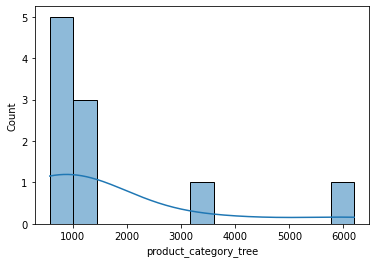

In [39]:
#trial plot
#I was having trouble plotting value_counts through sns, solved it alternatively below
sns.histplot(get_nth_category(df_new['product_category_tree'],level =1).value_counts()[0:10],kde=True)
plt.show()

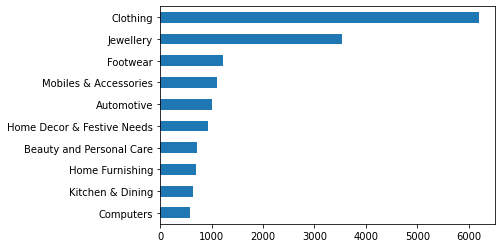

In [40]:
df_new['primary_cat'].value_counts()[0:10].sort_values().plot(kind = 'barh')

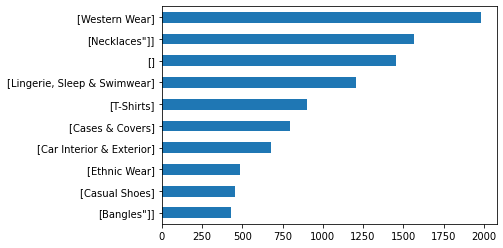

In [41]:
df_new['secondary_cat'].value_counts()[0:10].sort_values().plot(kind = 'barh')

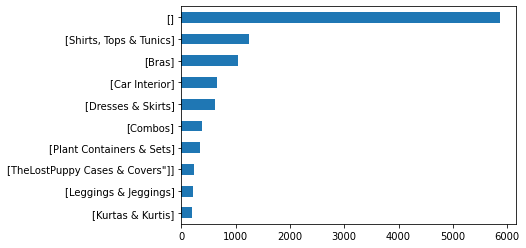

In [42]:
df_new['tertiary_cat'].value_counts()[0:10].sort_values().plot(kind = 'barh')

As can be seen from the above graphs, category 2 onwards has a lot of empty cells. This means that the categorization for sub categories might be classified as empty. 

For this specific task, I will keep sub category 2 in the interest of further experimentation, but since the probability of prediciting an empty class seems high simply based on it's prevelance in the data, it will not be included into the baseline model.

In [43]:
df_new=df_new.drop(columns=['tertiary_cat','quaternary_cat','quinary_cat'],axis=1)

In [44]:
df_new=df_new.drop(columns=['product_category_tree'],axis=1)

In [45]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             20000 non-null  object 
 1   is_FK_Advantage_product  20000 non-null  bool   
 2   description              19998 non-null  object 
 3   brand                    14136 non-null  object 
 4   discount                 19922 non-null  float64
 5   primary_cat              20000 non-null  object 
 6   secondary_cat            20000 non-null  object 
dtypes: bool(1), float64(1), object(5)
memory usage: 957.2+ KB


Seeing that brand has a lot of non-null values, it would make sense to see how many brand names are actually not present in the corresponding description. If it is not considerable, we can drop it.

Same applies for product name as well

Now let's convert the columns that have strings into the string datatype.

In [46]:
df_new["product_name"] = df_new["product_name"].astype('str')
df_new["description"] = df_new["description"].astype('str')
df_new['primary_cat'] = df_new['primary_cat'].astype('str')
df_new["product_name"] = df_new["product_name"].astype('str')
df_new["secondary_cat"] = df_new["secondary_cat"].astype('str')

In [47]:
df_new["brand"] = df_new["brand"].astype('str')

###In the following block, I will be defining a function to check for the presense of a sub-string in a string. This will be used to check for the presence of product name and brand name in the Description. If there is no unique benefit to product name and brand name, we can drop them.

1. Product Name -> Description

In [48]:
def check(string, sub_str):
  if (string.find(sub_str) == -1 and sub_str!='nan'):
    return 1;

In [49]:
k=0
for i in range(20000):
  x=check(df_new['description'][i],df_new['product_name'][i])
  if(x==1):
    k=k+1;
    x=0;

In [50]:
print(k,"Unique product names/ 20000 products") #Number of unique product names not present in the description

8 Unique product names/ 20000 products


 2. Brand -> Description

In [51]:
k=0
for i in range(20000):
  x=check(df_new['description'][i],df_new['brand'][i])
  if(x==1):
    k=k+1;
    x=0;

In [52]:
print(k,"Unique brand names/ 20000 products")

1001 Unique brand names/ 20000 products


Out of 20000 brand values, there are ~6000 null values, out of the remaining 14136 brand values, only 13135 are already present in the description. Due to this distribution, it might not have a major contribtion to the problem. However, this hypothesis can only be proven through implementation. Instead of testing, it would be safer to include the 1001 points to the description and create a more uniform and complete dataset.

In [53]:
lis=[] # list of brand names not in description
for i in range(20000):
  x=check(df_new['description'][i],df_new['brand'][i])
  if(x==1):
    lis.append(i)
    x=0;

In [54]:
for index in lis:
  df_new['description'][index]= df['brand'][index] + df_new['description'][index] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Checking whether all brand names are present in description now:

In [55]:
k=0
for i in range(20000):
  x=check(df_new['description'][i],df_new['brand'][i])
  if(x==1):
    k=k+1;
    x=0;

In [56]:
print(k,"Unique brand names/ 20000 products")

0 Unique brand names/ 20000 products


Now we drop the product_name and brand columns

In [57]:
df_new=df_new.drop(columns=['product_name','brand'],axis=1)

###Now we clean all the columns

In [58]:
df_new.head()

,is_FK_Advantage_product,description,discount,primary_cat,secondary_cat
0,False,Key Features of Alisha Solid Women's Cycling S...,62.062062,Clothing,"['Lingerie, Sleep & Swimwear']"
1,False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,29.576764,Furniture,['Sofa Beds & Futons']
2,False,Key Features of AW Bellies Sandals Wedges Heel...,50.050050,Footwear,['Ballerinas']
3,False,Key Features of Alisha Solid Women's Cycling S...,61.802575,Clothing,"['Lingerie, Sleep & Swimwear']"
4,False,Specifications of Sicons All Purpose Arnica Do...,4.545455,Pet Supplies,['Skin & Coat Care']


In [59]:
def clean_text(text): #removing
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+-', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    stop_words = set(stopwords.words('english')) 
    word_tokens = text.split()
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
      if w not in stop_words: 
        filtered_sentence.append(w)
    text=' '.join(filtered_sentence)
    text = re.sub('\w*\d\w*', '', text)
    return text



def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(str(text))
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text


def get_top_n_words(corpus,ngram_range=(1,1), n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatizer(text):        
    # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

####First, we work with the description column

In [60]:
df_new["description"] = df_new["description"].apply(text_preprocessing)
df_new["description"] = df_new["description"].apply(lemmatizer)
df_new=df_new.drop_duplicates(subset = ["description"],ignore_index=True)
df_new=df_new.replace({'-PRON-': ''}, regex=True)
freq_n_words = get_top_n_words(df_new["description"],n=30)
print(freq_n_words)

[('buy', 7678), ('online', 7636), ('flipkartcom', 7133), ('price', 6566), ('feature', 6175), ('brand', 5869), ('rs', 5848), ('color', 5629), ('day', 5299), ('free', 5263), ('product', 4981), ('type', 4851), ('genuine', 4846), ('delivery', 4785), ('replacement', 4750), ('cash', 4741), ('shipping', 4729), ('guarantee', 4535), ('womens', 4412), ('casual', 4302), ('general', 4249), ('design', 4235), ('material', 4179), ('fabric', 4136), ('print', 4111), ('box', 3950), ('make', 3884), ('india', 3597), ('collection', 3563), ('pack', 3548)]


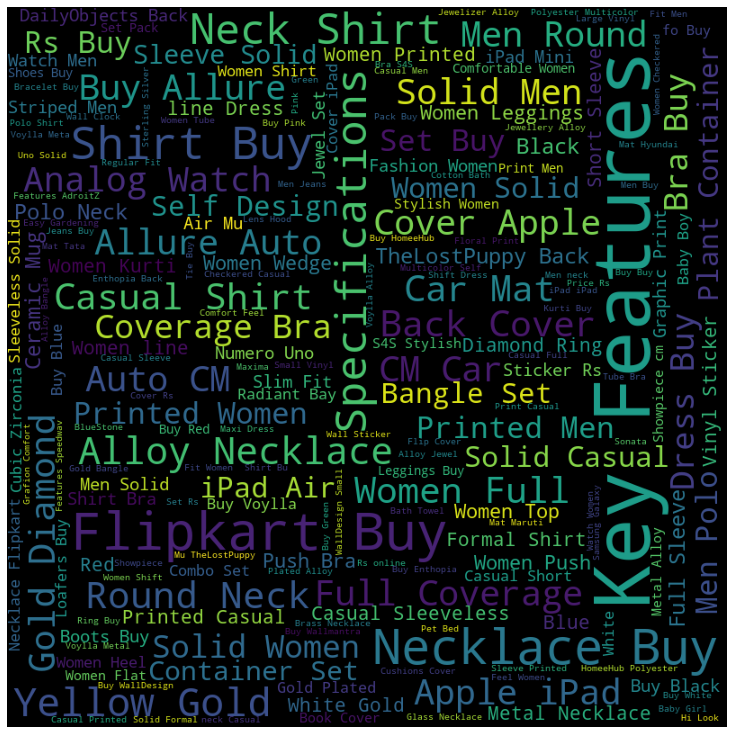

In [108]:

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(word for word in df.description.to_string().split())
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(text)

# Display the generated image:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [62]:
wine_mask = np.array(Image.open("/content/wine_mask.png"))
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
transformed_wine_mask = np.ndarray((wine_mask.shape[0],wine_mask.shape[1]), np.int32)

for i in range(len(wine_mask)):
    transformed_wine_mask[i] = list(map(transform_format, wine_mask[i]))

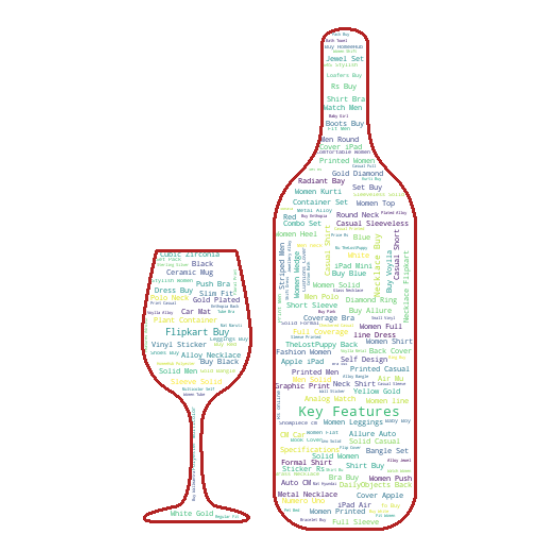

In [63]:
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
              contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(text)

# store to file
wc.to_file("/content/wine.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [64]:
new=pd.DataFrame()
new['text_len'] = df_new['description'].astype(str).apply(len)
new['word_count'] = df_new['description'].apply(lambda x: len(str(x).split()))

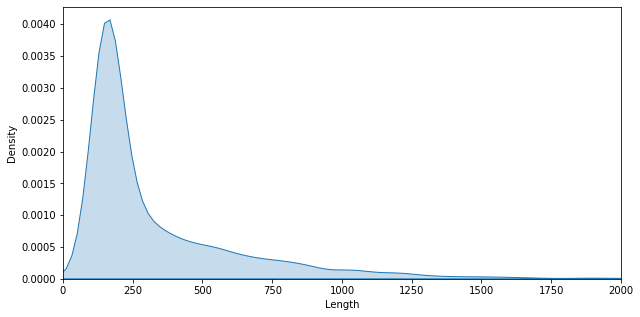

In [65]:
plt.figure(figsize=(10,5))
plt.xlim(0,2000)
plt.xlabel('Length')
plt.ylabel('Density')
sns.kdeplot(new['text_len'],shade=True)
plt.show()

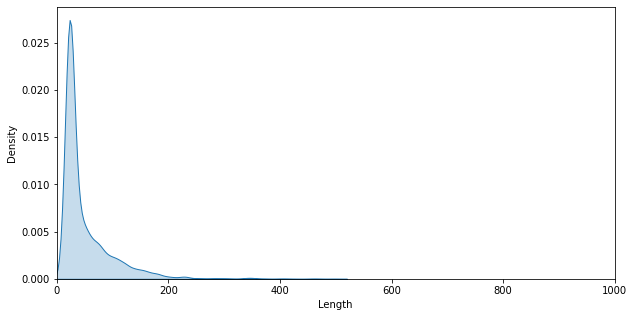

In [66]:
plt.figure(figsize=(10,5))
plt.xlim(0,1000)
plt.xlabel('Length')
plt.ylabel('Density')
sns.kdeplot(new['word_count'],shade=True)
plt.show()

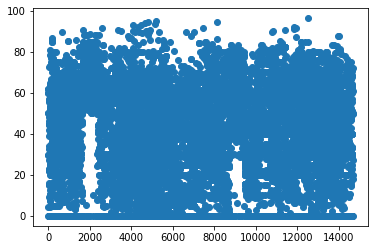

In [67]:
plt.scatter(df_new.index,df_new['discount'])
plt.show()

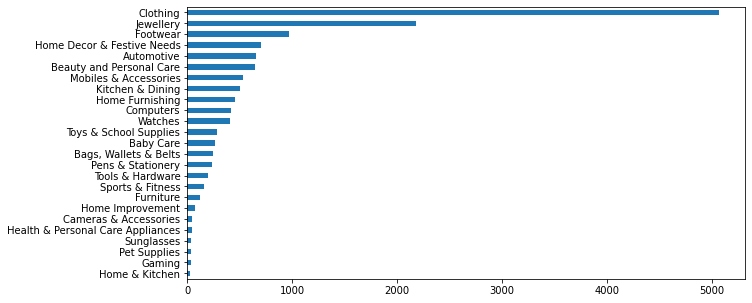

In [68]:
plt.figure(figsize=(10,5))
df_new['primary_cat'].value_counts()[0:25].sort_values().plot(kind = 'barh')

Seeing the data distribution in the graph above , it can be noted that the distribution is imbalanced on a large scale across all products. As a mechanism of limiting variables that may affect the outright loss suffered by the model, I will be capping it at 11 variables. 





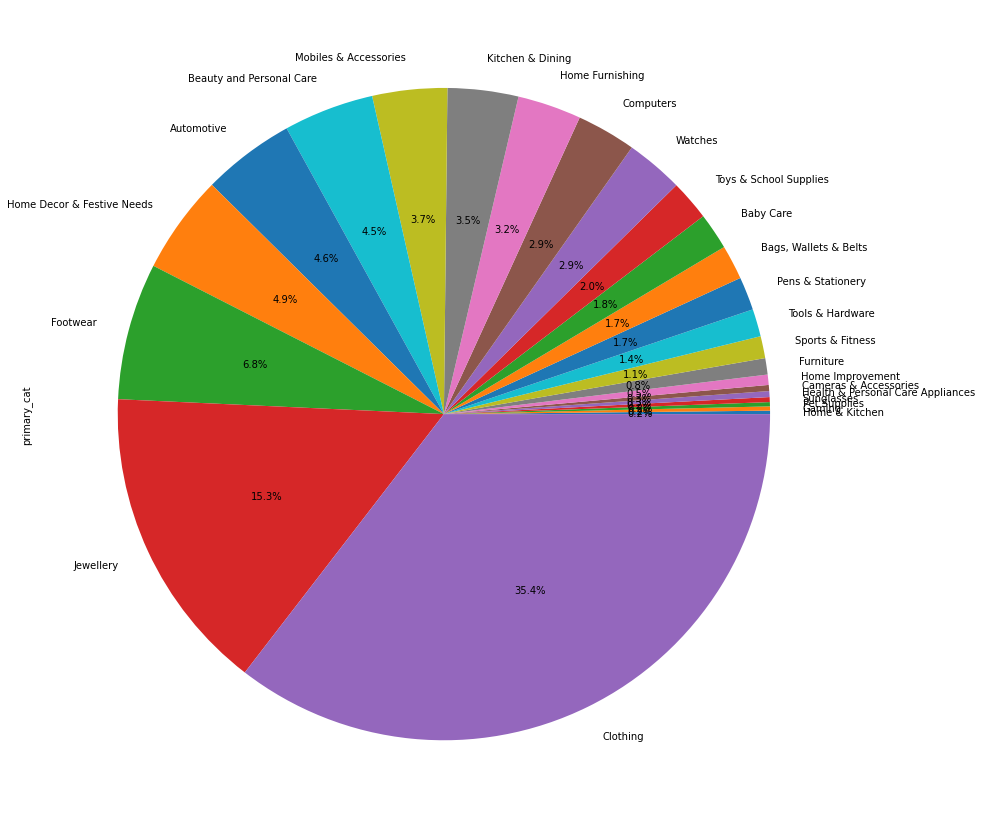

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df_new['primary_cat'].value_counts()[0:25].sort_values().plot.pie( autopct = '%1.1f%%')

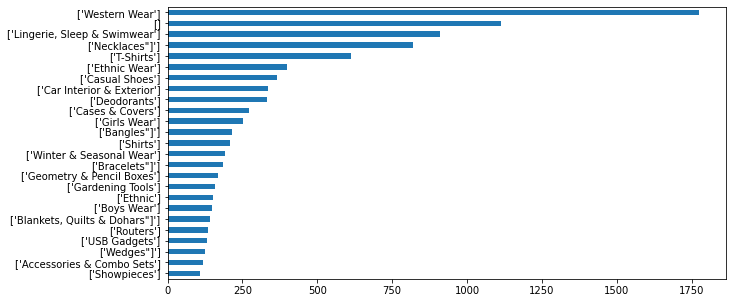

In [69]:
plt.figure(figsize=(10,5))
df_new['secondary_cat'].value_counts()[0:25].sort_values().plot(kind = 'barh')

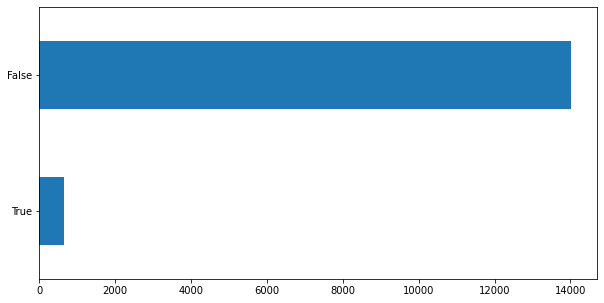

In [70]:
plt.figure(figsize=(10,5))
df_new['is_FK_Advantage_product'].value_counts()[0:25].sort_values().plot(kind = 'barh')

Given the highly imbalanced distribution in the graph, it would be safe to assume that this column is not going to be contributing Positively to the task at hand.

In [71]:
df_new=df_new.drop(columns=['is_FK_Advantage_product'])

In [72]:
first_cat_top = df_new['primary_cat'].value_counts()[:11].index.tolist()
processed_first=df_new[df_new['primary_cat'].isin(first_cat_top)].reset_index()


sec_cat_top = df_new['secondary_cat'].value_counts()[:11].index.tolist()
processed_second=df_new[df_new['secondary_cat'].isin(sec_cat_top)].reset_index()

##Let's  start off with modelling

###Models with Primary Category

####A simple baseline model using description and primary category (TF-IDF)

The reason I have used TF-IDF as my baseline is because of it's simplistic nature. It is quick to implement, does not require a lot of computing power, and is suprisingly effective on general NLP tasks.

What is TF-IDF?
TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

Term Frequency: This summarizes how often a given word 
appears within a document.

Inverse Document Frequency: This downscales words that appear a lot across documents.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(processed_first['description'],processed_first['primary_cat'],test_size=0.2) #splitting into train and test splits for model evaluation

In [74]:
vectorizer = TfidfVectorizer(stop_words = 'english') #tokenizes documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.
# Removing stop words
X_train_tfidf = vectorizer.fit_transform(X_train) #converting into vector representation using TF-IDF formula

In [75]:
classy=MultinomialNB()
# Defining model
classy.fit(X_train_tfidf, y_train)
# Fitting to multinomial NB model 
print(classy.score(X_train_tfidf, y_train))
# Scoring the trained model (Expected to be above 95 percent)
X_test_tfidf = vectorizer.transform(X_test) 
# Converting the test data
predicted_result=classy.predict(X_test_tfidf)
print(classification_report(y_test,predicted_result))
# print (clf2.score(X_test_tfidf, y_test))

0.9438403990024937
                            precision    recall  f1-score   support

                Automotive       0.95      0.93      0.94       129
  Beauty and Personal Care       1.00      0.72      0.84       122
                  Clothing       0.93      1.00      0.96      1059
                 Computers       0.98      0.67      0.80        83
                  Footwear       1.00      0.89      0.94       208
Home Decor & Festive Needs       0.98      0.92      0.95       128
           Home Furnishing       0.97      0.60      0.74        95
                 Jewellery       0.79      0.99      0.88       397
          Kitchen & Dining       1.00      0.68      0.81       101
     Mobiles & Accessories       0.89      0.82      0.85        98
                   Watches       1.00      0.89      0.94        87

                  accuracy                           0.92      2507
                 macro avg       0.95      0.83      0.88      2507
              weighted avg 

In [76]:
model = LinearSVC() #testing with SVM model. 
#Reasoning for this is because Naive Bayes considers all variables independantly, which SVM can bring about contextual understanding between labels
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

                            precision    recall  f1-score   support

                Automotive       0.98      0.97      0.97       129
  Beauty and Personal Care       1.00      0.99      1.00       122
                  Clothing       1.00      1.00      1.00      1059
                 Computers       0.99      0.98      0.98        83
                  Footwear       1.00      1.00      1.00       208
Home Decor & Festive Needs       0.98      1.00      0.99       128
           Home Furnishing       0.99      0.99      0.99        95
                 Jewellery       0.99      0.99      0.99       397
          Kitchen & Dining       0.99      0.98      0.99       101
     Mobiles & Accessories       0.97      0.98      0.97        98
                   Watches       1.00      1.00      1.00        87

                  accuracy                           0.99      2507
                 macro avg       0.99      0.99      0.99      2507
              weighted avg       0.99      0.9

Causality of better performance: The only conclusion that can be drawn from this , based on the working of both classifiers , is that SVM does not consider the features independantly, and looks at their interactions to a certain degree





####Creating an ensemble model with 3 base(Level 1) classifiers and 1 Level 2 classifier

In [77]:
vectorizer = TfidfVectorizer(stop_words = 'english')
# Removing stop words
stack_train = vectorizer.fit_transform(processed_first['description'])
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = MultinomialNB()
lr = LinearSVC()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, stack_train, processed_first['primary_cat'], cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


3-fold cross validation:

Accuracy: 0.94 (+/- 0.01) [KNN]
Accuracy: 0.92 (+/- 0.03) [Random Forest]
Accuracy: 0.83 (+/- 0.03) [Naive Bayes]
Accuracy: nan (+/- nan) [StackingClassifier]


Unfortunately, I could not get the stacking classifier to work. 

####Expanding to an embedding based model

**What are embeddings?**

A word embedding is a learned representation for text where words that have the same meaning have a similar representation.

Each word is represented by a real-valued vector, often tens or hundreds of dimensions. This is contrasted to the thousands or millions of dimensions required for sparse word representations, such as a one-hot encoding.

**What have I used to embed my text?**

I have , for this task, used a Keras Embedding layer. This embedding layer comes up with a relation of the inputs in another dimension.

**Why an LSTM?**

LSTM's(Long Short-Term Memory) is a highly effective sequential architecture. The reason I picked it is multi-fold. 

A glaring limitation of Vanilla Neural Networks (and also Convolutional Networks) is that their API is too constrained: they accept a fixed-sized vector as input and produce a fixed-sized vector as output. 

Then came an RNN. RNN's although effective, cannot capture long term dependencies due to the vanishing gradient problem. This is solved by LSTM's due to their fascinating architecture involving 4 gates.


In [107]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(processed_first['description']) #Tokenises all features into individual works
len(tokenizer.word_index)
all_encoded_texts = tokenizer.texts_to_sequences(processed_first['description']) #converting tokens to sequences
all_encoded_texts = np.array(all_encoded_texts)
for i in range(5):
    print('Length of file', i, ':', len(all_encoded_texts[i]))

all_encoded_texts = sequence.pad_sequences(all_encoded_texts, maxlen=500) #padding sequences to ensure all embeddings are of the same shape

Length of file 0 : 50
Length of file 1 : 78
Length of file 2 : 49
Length of file 3 : 51
Length of file 4 : 54


In [79]:
le= preprocessing.LabelEncoder()
Y= le.fit(processed_first['primary_cat'])
Y_train=le.transform(processed_first['primary_cat']) #transforming the catergorical variables into numerical format
Y_train = Y_train[:, np.newaxis]
one_hot_encoder = OneHotEncoder(sparse=False)
all_labels = one_hot_encoder.fit_transform(Y_train) #one hot encoding for more robust model structure due to non-ordinal labels.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(all_encoded_texts, all_labels, test_size=0.2, random_state=11) #train-test split

In [81]:
model = Sequential()
model.add(Embedding(input_dim=19777, output_dim=32, input_length=500))
model.add(LSTM(100))
model.add(Dense(11, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [82]:
history = model.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/12
157/157 [==============================] - 100s 625ms/step - loss: 1.7278 - accuracy: 0.4609 - val_loss: 0.9157 - val_accuracy: 0.6629
Epoch 2/12
157/157 [==============================] - 95s 605ms/step - loss: 0.8296 - accuracy: 0.6942 - val_loss: 0.6228 - val_accuracy: 0.7830
Epoch 3/12
157/157 [==============================] - 96s 613ms/step - loss: 0.4580 - accuracy: 0.8597 - val_loss: 0.2958 - val_accuracy: 0.9174
Epoch 4/12
157/157 [==============================] - 95s 608ms/step - loss: 0.2062 - accuracy: 0.9450 - val_loss: 0.2897 - val_accuracy: 0.9095
Epoch 5/12
157/157 [==============================] - 95s 603ms/step - loss: 0.1550 - accuracy: 0.9569 - val_loss: 0.1558 - val_accuracy: 0.9565
Epoch 6/12
157/157 [==============================] - 94s 600ms/step - loss: 0.0635 - accuracy: 0.9838 - val_loss: 0.2177 - val_accuracy: 0.9410
Epoch 7/12
157/157 [==============================] - 94s 599ms/step - loss: 0.0549 - accuracy: 0.9880 - val_loss: 0.1556 - val_a

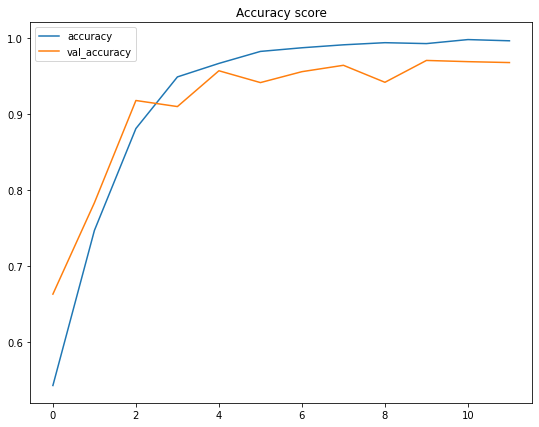

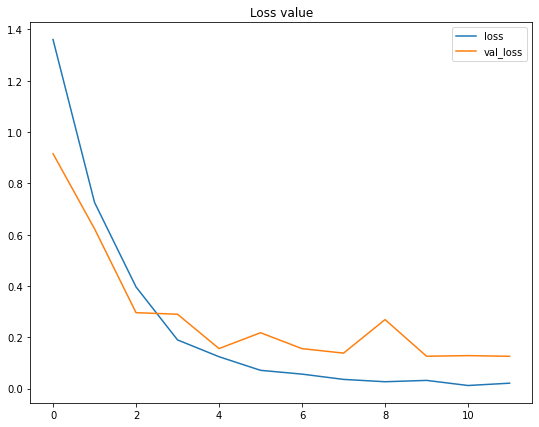

In [83]:
plt.figure(figsize=(9,7))
plt.title('Accuracy score')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(9,7))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [84]:
model.save('/content/my_model.h5')

As can be seen , the model has achieved a considerable accuracy, but the TFIDF model has still beaten it on accuracy. Why might this be the case?

The effectiveness of LSTM vs. other models is on it's ability to remember past embeddings and extract useful relationships. However, here the text length considered is 500, which means the text length is not enough to justify it's use. Furthermore, an important part to note is that the text data is not sequential i.e it does not need to follow a specific order, which means LSTM's although still effective, are probably not the right tool to use.

#####Predicting primary category with discount

This is an experiment I am choosing to do to understand the relationship between the discount and the product category. If this turns out to provide good results, it might be useful to combine this with the tfidf model to create an ensemble model.

In [85]:
train_set_disc=processed_first.dropna()

In [86]:
discount_train=train_set_disc['discount']

In [87]:
Y= le.fit(train_set_disc['primary_cat'])
Y_train=le.transform(train_set_disc['primary_cat'])

In [88]:
X_train_discount, X_test_discount, y_train_discount, y_test_discount = train_test_split(discount_train,Y_train,test_size=0.2)

In [89]:
model = MultinomialNB()
model.fit(X_train_discount.values.reshape(-1,1), y_train_discount)
y_pred = model.predict(X_test_discount.values.reshape(-1,1))
print(metrics.classification_report(y_test_discount, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.00      0.00      0.00       127
           2       0.40      1.00      0.57       998
           3       0.00      0.00      0.00        74
           4       0.00      0.00      0.00       192
           5       0.00      0.00      0.00       139
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       443
           8       0.00      0.00      0.00        97
           9       0.00      0.00      0.00       107
          10       0.00      0.00      0.00        84

    accuracy                           0.40      2497
   macro avg       0.04      0.09      0.05      2497
weighted avg       0.16      0.40      0.23      2497



This shows that data had little to no correlation to the primary category, so it would be harmful to include this as part of an ensemble model. THis column will therefore not be selected for further use.

###Model with secondary category

####A simple TF-IDF model implemented for this category as shown before.

I have included the empty class label to maintain the prevelance of a high number of datapoints during model implementation. I also wanted to analyse the effect that the empty category might have on the model.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(processed_second['description'],processed_second['secondary_cat'],test_size=0.2) #train-test split

In [91]:
vectorizer = TfidfVectorizer(stop_words = 'english') #same tf-idf implementation as before, only on the secondary category
X_train_tfidf = vectorizer.fit_transform(X_train)
classy=MultinomialNB()
# Defining model
classy.fit(X_train_tfidf, y_train)
# Fitting to multinomial NB model 
print(classy.score(X_train_tfidf, y_train))
# Scoring the trained model (Expected to be above 95 percent)
X_test_tfidf = vectorizer.transform(X_test) 
# Converting the test data
predicted_result=classy.predict(X_test_tfidf)
print(classification_report(y_test,predicted_result))

0.9040166927490871
                                precision    recall  f1-score   support

   ['Car Interior & Exterior']       0.98      1.00      0.99        65
            ['Cases & Covers']       1.00      0.87      0.93        55
              ['Casual Shoes']       1.00      0.67      0.80        73
                ['Deodorants']       0.99      0.97      0.98        72
               ['Ethnic Wear']       0.95      0.53      0.68        80
                ['Girls Wear']       0.00      0.00      0.00        47
['Lingerie, Sleep & Swimwear']       0.94      0.96      0.95       179
               ['Necklaces"]']       0.95      0.98      0.97       187
                  ['T-Shirts']       1.00      0.96      0.98       119
              ['Western Wear']       0.75      1.00      0.86       351
                            []       0.87      0.84      0.85       210

                      accuracy                           0.88      1438
                     macro avg       0.86  

####LSTM for secondary category

We will test the hypothesis we formed about LSTM's in the last implementation on the primary category.

In [92]:
#tokenizing and encoding data into padded sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_second['description'])
len(tokenizer.word_index)
all_encoded_texts = tokenizer.texts_to_sequences(processed_second['description'])
all_encoded_texts = np.array(all_encoded_texts)
for i in range(5):
    print('Length of file', i, ':', len(all_encoded_texts[i]))

all_encoded_texts = sequence.pad_sequences(all_encoded_texts, maxlen=500)

Length of file 0 : 50
Length of file 1 : 49
Length of file 2 : 101
Length of file 3 : 51
Length of file 4 : 51


In [102]:
#one hot encoding the data and creating a train test split
le= preprocessing.LabelEncoder()
Y= le.fit(processed_second['secondary_cat'])
Y_train=le.transform(processed_second['secondary_cat'])
Y_train = Y_train[:, np.newaxis]
one_hot_encoder = OneHotEncoder(sparse=False)
all_labels = one_hot_encoder.fit_transform(Y_train)
X_train, X_test, y_train, y_test = train_test_split(all_encoded_texts, all_labels, test_size=0.2, random_state=11)

In [103]:
model = Sequential() #sequential model used for layering
model.add(Embedding(input_dim=19777, output_dim=32, input_length=500))# 19777 is the number of words in the vocabulary, embedded into a 32 dimension dense embedding
model.add(LSTM(100)) #LSTM Layer
model.add(Dense(11, activation='sigmoid')) #Dense layer to implement activation function

In [104]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) 

In [105]:
history = model.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/12
90/90 [==============================] - 59s 631ms/step - loss: 2.1286 - accuracy: 0.2876 - val_loss: 1.2633 - val_accuracy: 0.4924
Epoch 2/12
90/90 [==============================] - 55s 617ms/step - loss: 1.0730 - accuracy: 0.6291 - val_loss: 0.7734 - val_accuracy: 0.7316
Epoch 3/12
90/90 [==============================] - 55s 616ms/step - loss: 0.7100 - accuracy: 0.7683 - val_loss: 0.5661 - val_accuracy: 0.8199
Epoch 4/12
90/90 [==============================] - 56s 624ms/step - loss: 0.5140 - accuracy: 0.8417 - val_loss: 0.6965 - val_accuracy: 0.7865
Epoch 5/12
90/90 [==============================] - 56s 627ms/step - loss: 0.5370 - accuracy: 0.8468 - val_loss: 0.4413 - val_accuracy: 0.8762
Epoch 6/12
90/90 [==============================] - 57s 629ms/step - loss: 0.2912 - accuracy: 0.9142 - val_loss: 0.3207 - val_accuracy: 0.8999
Epoch 7/12
90/90 [==============================] - 56s 625ms/step - loss: 0.1961 - accuracy: 0.9366 - val_loss: 0.3589 - val_accuracy: 0.8894

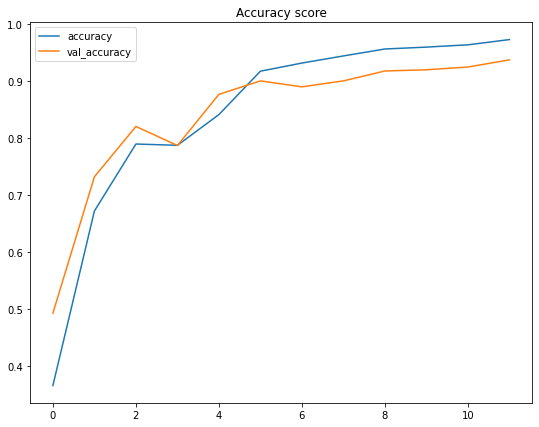

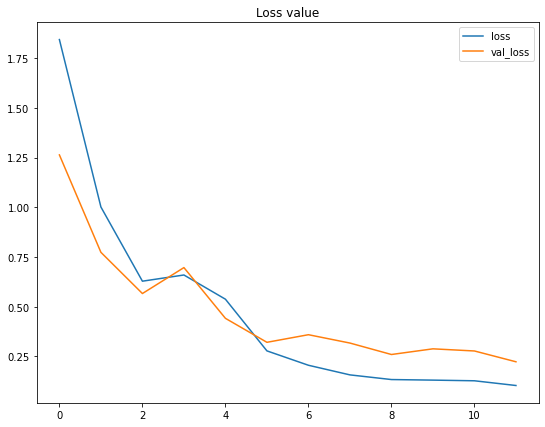

In [106]:
plt.figure(figsize=(9,7))
plt.title('Accuracy score')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(9,7))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

This result is quite interesting. The LSTM proves to be more accurate than the TF-IDF model. This does show that there is some benefit we should provide to the long term dependency effectiveness it provides. However, this result is highly stochastic, because the accuracy has ranged from 0.69-0.94 in validation on multiple implementations

##Methods of Increasing Accuracy:

Data Oversampling : Although we were able to achieve a high accuracy, it would be interesting to see how we could further improve the accuracy in classes with lower numbers of data. This could be done using SMOTE or using data augmentation techniques such as back-translation, text generation etc.

Better networks: This has been explained below in the future approaches section.

## Going forward, what kind of methods can we focus on?

There are several approaches we can explore based on my preliminary research.


1.   Deep Neural Networks: It would be interesting to analyse the effectiveness of training this data over a considerable number of layers in a neural network, and compare the performance with LSTM to further interpret the applicability of long term dependancies in this dataset.

1.   Transformers: Attention has changed the landscape of NLP. Given that they are non sequential, the long term dependancy issue does not take place if present, but moreover self-attention and positional embeddings are interesting concepts that may have an impact on larger datasets.

1.   Self-Supervised Learning: This has always interested me and is definitely a mechanism to be explored. The ability for self-supervised learning to explore semantic relationships has been shown before,and through clustering methods, it would be interesting to explore this 

2.   Meta -learning for few shot classification: Learning to learn is the basis of meta learning, and reducing this task to a few shot prediction would be immensely beneficial.

